In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pycbc.inference import io, models
from pycbc import waveform
from pycbc.detector import Detector

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [2]:
def fn_to_waveform(fn):       
    # read in the raw posterior file and extract the max loglikelihood parameter value
    with io.loadfile(fn, 'r') as fp:   
        data = fp.read_data()                                                           
        psds = fp.read_psds()                                                           
        cp = fp.read_config_file()
        samples = fp.read_samples(list(fp['samples'].keys()))
        idx = samples['loglikelihood'].argmax()
        params = {p: samples[p][idx] for p in samples.fieldnames}
    # set up the model
    model = models.read_from_config(cp, data=data, psds=psds)
    model.update(**params)
    _ = model.loglikelihood
    pol = model.current_stats['maxl_polarization']
    #compute the max loglikelihood waveform
    wfs = model.waveform_generator.generate(polarization=pol,**model.current_params)
    
    whdata = {}
    for det in model.data:
        d = model.data[det]
        d = d.copy()
        d *= model.weight[det] / (4*model.psds[det].delta_f)**0.5
        whdata[det] = d.to_timeseries()
    
    waveforms = {}
    whitened_waveforms = {}
    for detname in wfs:
        hs = {}
        whitend_hs = {}
        det = Detector(detname)
        fp, fc = det.antenna_pattern(model.current_params['ra'],
                                     model.current_params['dec'],
                                     pol,
                                     model.current_params['tc'])
        hp, hc = wfs[detname]
        h = fp*hp + fc*hc
        h.resize(len(model.weight[detname]))
        wh = h.copy()
        wh *= model.weight[detname] / (4*model.psds[detname].delta_f)**0.5
        whitened_waveforms[detname] = wh.to_timeseries() 
    return whdata, whitened_waveforms,model

In [3]:
parity_path = '/work/yifan.wang/gw190521_xrerun/t3-localrun/0_550/result.hdf'
parity_whdata, parity_whwaveform, parity_model = fn_to_waveform(parity_path)

#gr_path = '/work/yifan.wang/gw190521_xrerun/t1-mpi-gr/mpirun_output/config_files/result.hdf'
gr_path = '/work/yifan.wang/gw190521_xrerun/t1-mpi-gr/mpirun_output/config_files/result.hdf'
_, gr_whwaveform,gr_model = fn_to_waveform(gr_path)

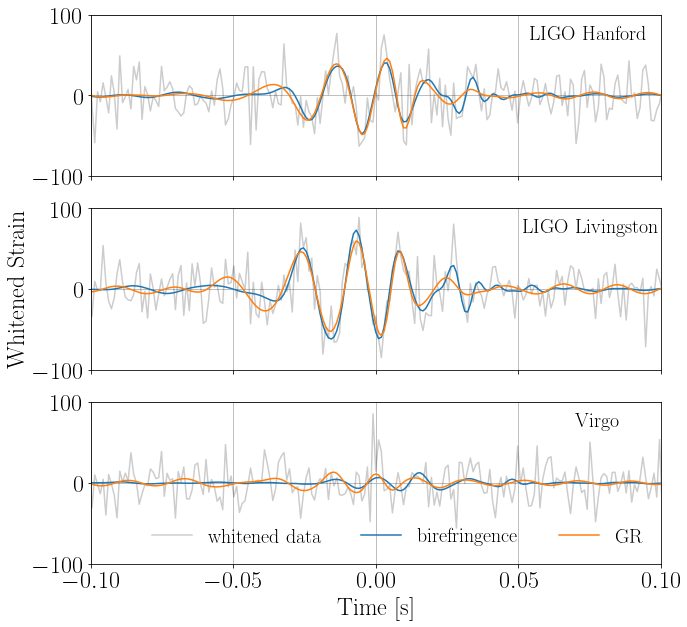

In [4]:
xlim=(-0.1, 0.1)
fig = plt.figure(figsize=(10.211706102117061, 6.311181454233049*1.6))
fig.subplots_adjust(hspace=.2)
ax = fig.add_subplot(311);

tc = parity_model.static_params['trigger_time']
det = list(gr_whwaveform.keys())
wdata = parity_whdata[det[0]]
ax.plot(wdata.sample_times-tc, wdata, c='k', alpha=0.2, label='whitened data')

wwf = parity_whwaveform[det[0]]
ax.plot(wwf.sample_times-tc, wwf,label='birefringence')
ax.plot(gr_whwaveform[det[0]].sample_times-tc, gr_whwaveform[det[0]],label='GR')

ax.grid(True)
ax.set_xticklabels([])
ax.set_xlim(*xlim)
ax.set_ylim(-100,100)
ax.text(0.054, 70, 'LIGO Hanford', style='italic',fontsize=20,
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5,'edgecolor':'none'})

################
bx = fig.add_subplot(312);
wdata = parity_whdata[det[1]]
bx.plot(wdata.sample_times-tc, wdata, c='k', alpha=0.2, label='whitened data')
    
wwf = parity_whwaveform[det[1]]
bx.plot(wwf.sample_times-tc, wwf,label='birefringence')
bx.plot(gr_whwaveform[det[1]].sample_times-tc, gr_whwaveform[det[1]],label='GR')

bx.set_ylabel('Whitened Strain')
bx.set_xlim(*xlim)
bx.set_ylim(-100,100)
bx.text(0.0515, 70, 'LIGO Livingston', style='italic',fontsize=20,
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':0,'edgecolor':'none'})
bx.grid(True)
bx.set_xticklabels([])

################
cx = fig.add_subplot(313);
wdata = parity_whdata[det[2]]
cx.plot(wdata.sample_times-tc, wdata, c='k', alpha=0.2, label='whitened data')
    
wwf = parity_whwaveform[det[2]]
cx.plot(wwf.sample_times-tc, wwf,label='birefringence')
cx.plot(gr_whwaveform[det[2]].sample_times-tc, gr_whwaveform[det[2]],label='GR')
cx.text(0.07, 70, 'Virgo', style='italic',fontsize=20,
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5,'edgecolor':'none'})

cx.set_xlim(*xlim)
cx.set_ylim(-100,100)
cx.set_xlabel('Time [s]')
cx.legend(loc='lower right', ncol=3,framealpha=0)
fig.savefig('1124_gw190521.pdf',bbox_inches='tight')

In [5]:
parity_model.current_params

{'loglikelihood': -27862.587034617434,
 'spin1_a': 0.905760370062339,
 'q': 4.604661012059659,
 'parity_mpvinverse': 524.2753151337122,
 'ra': 3.3298846773746726,
 'logwt': -27907.29942400331,
 'spin1_polar': 1.9165479311929257,
 'spin2_azimuthal': 2.5418720868611406,
 'comoving_volume': 5977742169.868624,
 'dec': 0.512136845042128,
 'srcmchirp': 60.215369361157165,
 'spin2_polar': 2.399028465257018,
 'delta_tc': 0.006884290349553457,
 'spin1_azimuthal': 2.3867100805570907,
 'coa_phase': 3.053881460939539,
 'spin2_a': 0.7737867301521402,
 'inclination': 1.33582259332741,
 'approximant': 'mpvnosmall',
 'baseapprox': 'IMRPhenomXPHM',
 'f_lower': 20.0,
 'f_ref': 20.0,
 'trigger_time': 1242442967.4473,
 'spin1x': -0.6206712642453288,
 'spin1y': 0.583901598182653,
 'spin1z': -0.30696572016320367,
 'spin2x': -0.4319134341549804,
 'spin2y': 0.29531073260830837,
 'spin2z': -0.5700774161132298,
 'tc': 1242442967.4541843,
 'redshift': 0.27219564064922364,
 'distance': 1432.3102047089094,
 'mass1